# Validation curves
In this notebook we will try to train an estimator over the training data, and every epoch, perform a evaluation on both the training data and the validation data. With this data we will plot the validation curves of the algorithm. 

We will also try to implement a mechanism to persist and restorethe model which achieved the best performance overall on the validation set and at the end use it to evaluate the model's generalization ability on the test set.

In [1]:
%matplotlib inline
# standard library
import itertools
import sys, os
import re
import glob

# pandas
import pandas as pd
import dask.dataframe as dd
import dask.array as da
import dask


# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# skealrn
from sklearn.metrics import precision_recall_fscore_support, classification_report, accuracy_score

# tesnsorflow
import tensorflow as tf

# local imports
sys.path.append(os.path.join(os.getcwd(), "../src"))

import tf_utils

# this styling is purely my preference
# less chartjunk
sns.set_context('notebook', font_scale=1.5, rc={'line.linewidth': 2.5})
sns.set(style='ticks', palette='Set2')

## Inputting the data
Using our in-memory caching dataset, we are going to load all the 3 datasets(train, validation, test) in memory.

In [2]:
# get the input functions and the initialization hooks to pass to the estimator
test_input_fn, test_init_hook = tf_utils.input_fn_from_csv('../data/final/cleaneval/dom-full-test-*.csv', precache=True)
train_input_fn, train_init_hook = tf_utils.input_fn_from_csv('../data/final/cleaneval/dom-full-train-*.csv', precache=True)
validation_input_fn, validation_init_hook = tf_utils.input_fn_from_csv('../data/final/cleaneval/dom-full-validation-*.csv', precache=True)

## Defining the model


In [3]:
# session workaround
sess_config = tf.ConfigProto()
sess_config.gpu_options.allow_growth = 1

config = tf.estimator.RunConfig(
    model_dir='/home/nikitautiu/cleaneval_models',
    save_checkpoints_steps=1000, 
    session_config=sess_config, 
)


# we can infer the columns from the function, a bit costly, but better than hardcoding
tf_feat_cols = tf.contrib.learn.infer_real_valued_columns_from_input_fn(lambda: train_input_fn(num_epochs=1, batch_size=1, shuffle_buffer=0))
estimator = tf.estimator.DNNClassifier(feature_columns=tf_feat_cols, hidden_units=(1000, 500, 200), 
                                        weight_column='weights', model_dir='/home/nikitautiu/cleaneval_models', config=config)


INFO:tensorflow:Using config: {'_is_chief': True, '_num_worker_replicas': 1, '_keep_checkpoint_max': 5, '_session_config': gpu_options {
  allow_growth: true
}
, '_task_type': 'worker', '_log_step_count_steps': 100, '_num_ps_replicas': 0, '_model_dir': '/home/nikitautiu/cleaneval_models', '_save_checkpoints_secs': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f48a30b7c88>, '_keep_checkpoint_every_n_hours': 10000, '_save_summary_steps': 100, '_save_checkpoints_steps': 1000, '_master': '', '_service': None, '_tf_random_seed': None}


Now that we have the model, we can build the infrastructure  for testing out the training process and returning the losses and other metrics.

In [282]:
def get_pred(estimator, input_fn, hooks=[]):
    """Given an input function and an estimator, return the d predicted labels"""
    # get prdeiction
    predicted_list = [pred['class_ids'] for pred in estimator.predict(input_fn, hooks=hooks)]
    pred_array = np.stack(predicted_list, axis=0).ravel()  # concatenate them to one
    
    return pred_array

def get_exp(estimator, input_fn, hooks=[]):
    """Given an input function and an estimator, return the expected labels"""
    # consume label tensors
    # not necessarily the most elegant solution but works
    label_tens = input_fn()[1]
    expected_list = []
    with tf.Session() as sess:
        for hook in hooks:
            hook.after_create_session(sess, None)  # must be ran
        # get each element of the training dataset until the end is reached
        while True:
            try:
                elem = sess.run(label_tens)
                expected_list.append(elem)
            except tf.errors.OutOfRangeError:
                break
            
    expected_array = np.concatenate(expected_list).ravel()
    return expected_array

def get_metrics(estimator, input_fn, init_hooks=[], exp_arr=None):
    if exp_arr is  None:
        exp_arr = get_exp(estimator, input_fn, init_hooks)
    pred_arr = get_pred(estimator, input_fn, init_hooks)
    class_rep = precision_recall_fscore_support(exp_arr, pred_arr)  # get the class report
    acc_score = accuracy_score(exp_arr, pred_arr)
    
    # build te stats and return
    return {
        'accuracy': acc_score,
        'precision': class_rep[0][1], # only for the positive class
        'recall': class_rep[1][1],
        'f1-score': class_rep[2][1],
        'support': class_rep[3][1],
        'support_other': class_rep[3][0]
    }


def train_eval_loop(estimator, train_input_fn_and_hook, num_epochs=1000, start_epoch=0, eval_input_fns_and_hooks={}):
    """Given a train input fn and hook and the same kind of pairs for the evaluation
    sets, return a dictionary of metrics for each set after every epoch."""
        
    # precache exp_arr
    expected_arrs = {
        eval_set_name: get_exp(estimator, eval_set_fn, hooks=[eval_set_hook])
        for eval_set_name, (eval_set_fn, eval_set_hook) in eval_input_fns_and_hooks.items()
    }
    
    # initialize the metrics
    metrics = {name: [] for name in eval_input_fns_and_hooks.keys()}
    
    # do the loop
    for epoch in range(1, num_epochs+1):
        # train for one epoch
        estimator.train(train_input_fn_and_hook[0], hooks=[train_input_fn_and_hook[1]])
        
        print('\nEVALUATION\n', '='*40)
        # evaluate on sets
        for eval_set_name, (eval_set_fn, eval_set_hook) in eval_input_fns_and_hooks.items():
            evaluated_metrics = get_metrics(estimator, eval_set_fn, init_hooks=[eval_set_hook], exp_arr=expected_arrs[eval_set_name])
            evaluated_metrics['epoch'] = start_epoch + epoch
            
            print(eval_set_name, " ---- ", evaluated_metrics, )  # print for progress check
            metrics[eval_set_name].append(evaluated_metrics)
        print('='*40, '\n')
   
    return metrics

## Train loop
Hacing implemented the helper functions we can now run a training loop for 2000 epochs.

In [ ]:
%%time
metrics = train_eval_loop(estimator, 
                          (lambda: train_input_fn(num_epochs=1, batch_size=2000, shuffle_buffer=50000), train_init_hook),
                          num_epochs=2000,
                          eval_input_fns_and_hooks= {
                                                        'train':  (lambda: train_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0), train_init_hook),
                                                        'validation': (lambda: validation_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0), validation_init_hook),
                                                        'test':  (lambda: test_input_fn(num_epochs=1, batch_size=5000, shuffle_buffer=0), test_init_hook),
                                                    })

The time(deleted the output for a more compact display)
```
CPU times: user 10h 34min 23s, sys: 1h 41min, total: 12h 15min 23s
Wall time: 11h 43min 15s
```
## Results and vizualization

In [277]:
validation_stats = pd.DataFrame(metrics['validation'])
train_stats = pd.DataFrame(metrics['train'])
test_stats = pd.DataFrame(metrics['test'])


def plot_metric(train_stats, validation_stats, test_stats, metric_name):
    # get the best epoch for validation
    best_epoch = validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
    best_index = test_stats['epoch'] == best_epoch

    # do a bit of smoothing 
    smooth_train = train_stats.rolling(center=False, window=21).mean().dropna()
    smooth_validation = validation_stats.rolling(center=False, window=21).mean().dropna()

    # do the plotting
    fig, ax = plt.subplots(figsize=(11, 7))
    smooth_train.plot(x='epoch', y=metric_name, ax=ax,  alpha=0.8, label='train', linewidth=1)
    smooth_validation.plot(x='epoch', y=metric_name, ax=ax, alpha=0.8, label='validation', linewidth=1)
    plt.plot(best_epoch, test_stats.loc[best_index, metric_name], 'o', label='test(for best validation)', alpha=0.8)

    plt.ylim(ymax=1.01)
    plt.title(metric_name)
    plt.legend(loc='lower right')
    sns.despine(fig=fig, ax=ax)

In [276]:
best_epoch = validation_stats.loc[validation_stats['f1-score'].idxmax(), 'epoch']
best_index = test_stats['epoch'] == best_epoch


print('BEST VALIDATION EPOCH - TEST RESULTS')
print(test_stats[best_index])

BEST VALIDATION EPOCH - TEST RESULTS
      accuracy  epoch  f1-score  precision    recall
1857  0.999075   1858  0.996884   0.997082  0.996686


### Accuracy

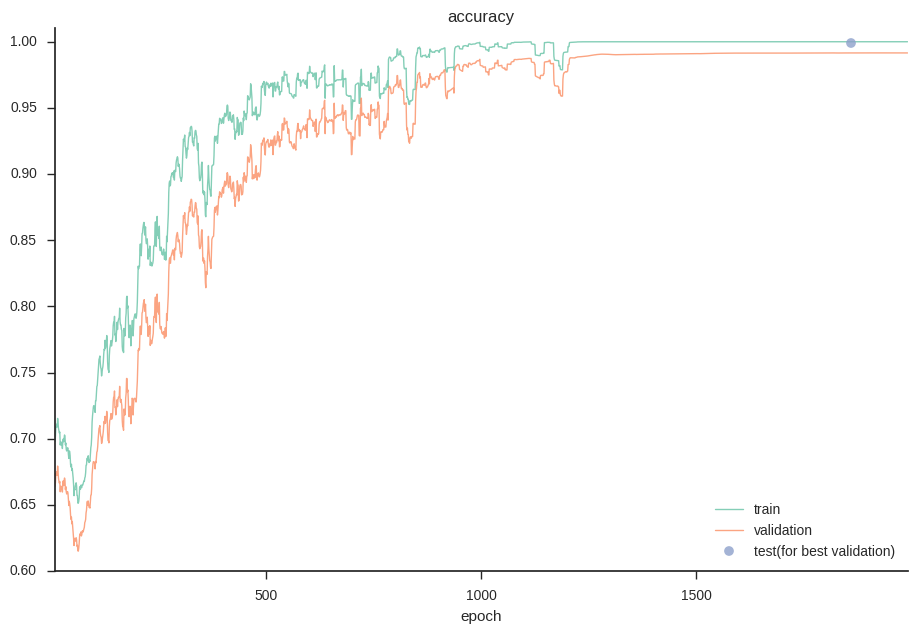

In [272]:
plot_metric(train_stats, validation_stats, test_stats, 'accuracy')

### Precision/Recall

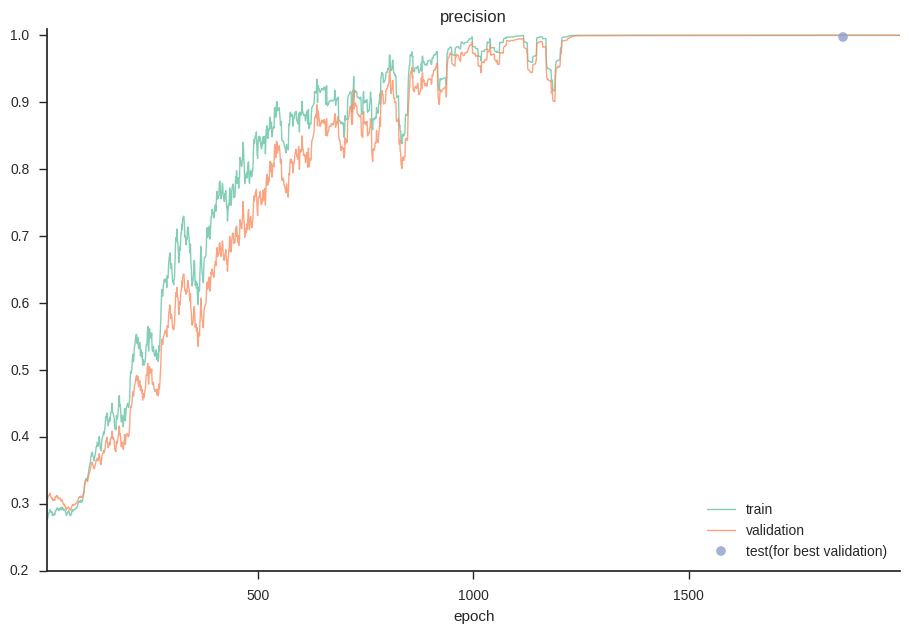

In [273]:
plot_metric(train_stats, validation_stats, test_stats, 'precision')

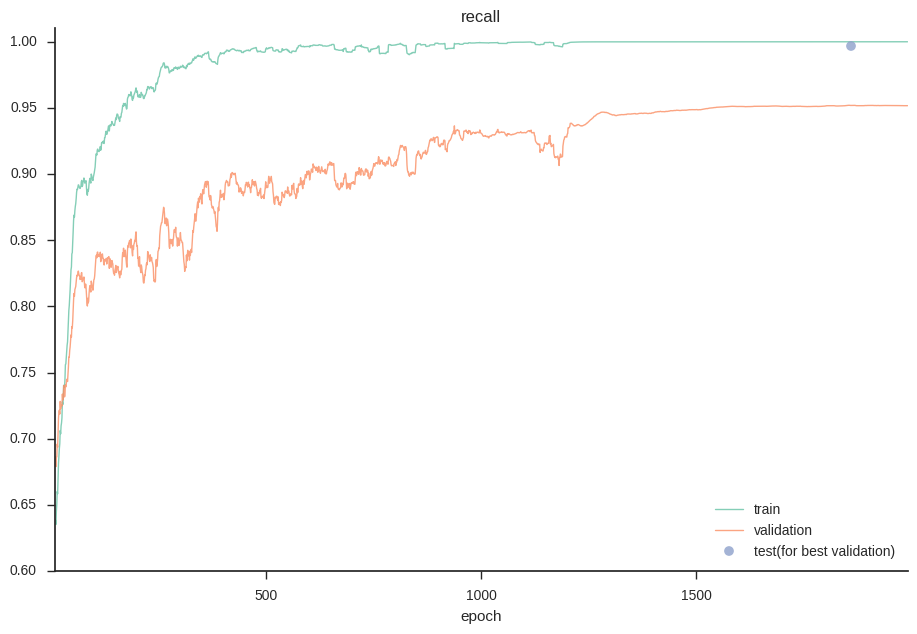

In [274]:
plot_metric(train_stats, validation_stats, test_stats, 'recall')

### F1-Score

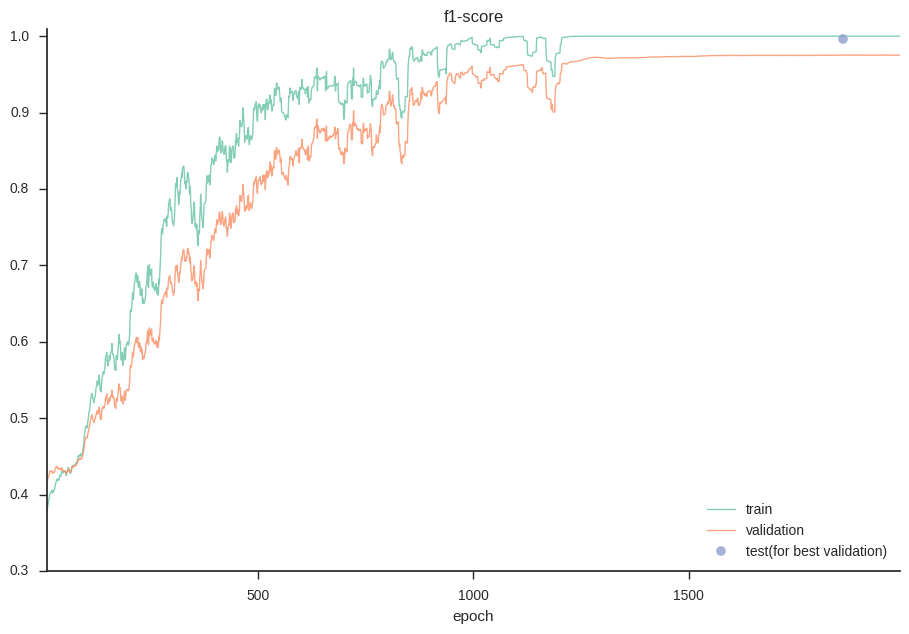

In [275]:
plot_metric(train_stats, validation_stats, test_stats, 'f1-score')

### Misc stats

In [278]:
# see the best values indxes for validation
validation_stats.idxmax()

accuracy     1857
epoch        1999
f1-score     1857
precision    1955
recall        647
dtype: int64

In [295]:
# also, here are the stats averaged over a rolling window of 50, resample in 50 steps
validation_stats.rolling(21, center=True).mean().dropna().iloc[1000::20].drop('epoch', axis=1)

,accuracy,f1-score,precision,recall
1010,0.977270,0.938470,0.954310,0.928733
1030,0.980134,0.944442,0.963309,0.929455
1050,0.980153,0.944932,0.962080,0.931578
1070,0.984658,0.955039,0.982469,0.929595
1090,0.986723,0.960686,0.991824,0.931464
1110,0.987328,0.962453,0.994227,0.932662
1130,0.973255,0.930770,0.946188,0.922802
1150,0.984980,0.955211,0.989555,0.923550
1170,0.966717,0.918430,0.934303,0.912530
1190,0.974891,0.931377,0.944205,0.923493


In case we need them later, we will persist the results.

In [298]:
pd.concat([train_stats.assign(set='train'), 
           validation_stats.assign(set='validation'), 
           test_stats.assign(set='test')]).to_csv('../data/experimental-results/cleaneval-validation-curves.csv')

## Conclusion
The validation curves look solid, an by looking at the indexes of the beest performanes on the validation set it looks like aroun the 1850-1900 mark, the performance seems to taper off and decrease. The performance is very good, but further confirmation should be done on different splits to have more statistically sound results.

The high similarity between the accuracy and precision could probably be traced to how skewed the dataset it, therefore small changes in performance on the training set would trainslate into changes for the other partitions as well due to the predominance of the negative class.